In [1]:
import gym
from gym import spaces
import random
from stable_baselines3 import PPO
import numpy as np

In [2]:
env = gym.make("CartPole-v1")

In [3]:
# Random_games()

In [4]:
class CartWorld():
    def __init__(self,env):
        self.env=env
    def run(self,agent=None,n_episodes=30,episode_maxlen=300):
        global world_over
        agent.observation_space=env.observation_space
        if 'training' not in agent.__dict__: agent.training=False
        world_over=False
        for episode in range(n_episodes):
            # print('CartAgent','starting episode')
            if world_over: break
            state=env.reset()
            agent.reset(state)
            for t in range(episode_maxlen):
                if world_over: break
                # env.render(mode='rgb_array')
                action=agent.act(env.state)
                # print('TrainingEnv queues:',agent.env.print_queues())
                next_state, reward, done, info = env.step(action)
                agent.reward((reward,done,info))
                # print('Monitor over:',agent.monitor.over,'TrainingEnv counter:',
                #       agent.env.counter)
                if done or world_over:
                    break
        return agent.avg_rew()

In [5]:
class RandomAgent():
    def __init__(self,action_space):
        self.action_space=action_space
        self.tot_rew=0
        self.rewL=[]
    def act(self,state):
        action = self.action_space.sample()
        return action
    def reward(self,rew):
        self.tot_rew+=rew[0]
    def reset(self,state):
        self.rewL+=[self.tot_rew]
    def avg_rew(self):
        return sum(self.rewL)/len(self.rewL)

In [6]:
# agent=PPOAgent(env.action_space)

In [7]:
# agent=RandomAgent(env.action_space)

In [8]:
world=CartWorld(env=env)

In [9]:
# world.run(agent,10,200)

In [10]:
# agent.rewL

### Training an AI Agent's Model using an off-the shelf RL procedure
Create a local environment called by a Monitor thread running within Agent, which implements or
re-uses an on-policy RL training procedure (such as PPO etc.). The env has an input and output queue. If a training flag is set, the Agent uses a ProxyModel place of its normal model to compute actions: The actor-state is placed in the env's input queue and an action is awaited from the env's output queue.

The monitor starts by calling the env.reset method that waits on the input queue to receive 
and then return a state. The monitor thread computes an action on the current state and calls
env.step(action), which places the action in the output queue and awaits a reward from the input
queue. After receiving a reward, step again waits for the next state on the input queue.
Once this is also received, both next stte and reward are returned.

In [11]:
from queue import Queue
from threading import Thread
import threading

In [15]:
class PPOAgent(RandomAgent):
    def __init__(self,action_space,observation_space,training_steps=20000):
        # self.model=model = PPO.load('ReinforcementLearningCourse-main/Training/Saved Models/PPO_model', env=env)
        super().__init__(action_space)
        self.env=self.TrainingEnv(parent=self)
        self.env.observation_space=observation_space
        self.model=PPO('MlpPolicy', self.env, verbose=0)
        self.monitor=self.Monitor(parent=self)
        # self.monitorthread=Thread(target=self.monitor.run) #For dubugging
        self.set_training(True)
        self.monitorthread=Thread(target=self.monitor.train,args=(training_steps,))
        self.monitorthread.start()
        self.tot_rew=0
        self.logL=[]
    
    def log(self,entry):
        self.logL+=[entry]
        
    def set_training(self,value):
        self.training=value
        
    class TrainingEnv(gym.Env):
        def __init__(self,parent):
            self.parent=parent
            self.action_space=spaces.Discrete(2)
            # self.observation_space=spaces.Box(
            #     low=np.array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38]), 
            #     high=np.array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38]), 
            #     shape=(4,), dtype=np.float32)
            self.inputS=Queue() #written by act read by reset and step
            self.outputS=Queue() #written by act read by act
            self.rewardI=Queue() #written by act and read by step
            self.actionO=Queue() #written by step and read by act
            self.counter=0
        def reset(self):
            # print('reset')
            state=self.inputS.get()
            return state
        def step(self,action):
            # print('step')
            self.actionO.put(action)
            reward,done,info=self.rewardI.get()
            next_state=self.inputS.get()
            self.counter+=1
            # print(self.counter,done)
            return next_state,reward,done,info
        def print_queues(self):
            print('inputS',self.inputS.queue)
            print('actionO',self.actionO.queue)
            print('rewardI',self.rewardI.queue)
            print('outputS',self.outputS.queue)
             
    class Monitor():
        def __init__(self,parent):
            self.parent=parent
        def run(self):
            state=env.reset()
            for episode in range(600):
                # env.render()
                action=self.parent.env.action_space.sample()
                next_state, reward, done, info = self.parent.env.step(action)
                print(next_state, reward, done, info, action)
            self.parent.monitorthread.join()
        def train(self,training_steps):
            global world_over
            self.parent.model.learn(total_timesteps=training_steps)
            print('Training Over')
            self.parent.set_training(False)
            self.parent.log((self.parent.training,self.parent))
        
    def act(self,state):
        if self.training:
            self.env.inputS.put(state)
            try: action = self.env.actionO.get(timeout=5)
            except: action=0
        else: action, _states = self.model.predict(state)
        return action
    def reward(self,reward):
        if self.training: self.env.rewardI.put(reward)
        super().reward(reward)
    def reset(self,state):
        self.rewL+=[self.tot_rew]
        # self.tot_rew=0
        if self.training: self.env.inputS.put(state)

In [24]:
agent=PPOAgent(env.action_space,env.observation_space,training_steps=10000)

In [25]:
agent.rewL=[]
agent.tot_rew=0

In [26]:
world=CartWorld(env=env)

In [27]:
world.run(agent,n_episodes=2000,episode_maxlen=200)

Training Over


114618.738

In [28]:
from matplotlib import pyplot as plt

In [29]:
np.gradient(agent.rewL).mean()

128.3115

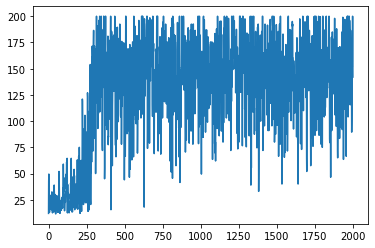

In [30]:
plt.plot(np.gradient(agent.rewL))

In [14]:
for thread in threading.enumerate(): 
    print(thread.name)

MainThread
Thread-4
Thread-5
Thread-6
Thread-7
Thread-3
IPythonHistorySavingThread
Thread-2


In [16]:
PPO??

Init signature:
PPO(
    policy: Union[str, Type[stable_baselines3.common.policies.ActorCriticPolicy]],
    env: Union[gym.core.Env, stable_baselines3.common.vec_env.base_vec_env.VecEnv, str],
    learning_rate: Union[float, Callable[[float], float]] = 0.0003,
    n_steps: int = 2048,
    batch_size: int = 64,
    n_epochs: int = 10,
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    clip_range: Union[float, Callable[[float], float]] = 0.2,
    clip_range_vf: Union[NoneType, float, Callable[[float], float]] = None,
    ent_coef: float = 0.0,
    vf_coef: float = 0.5,
    max_grad_norm: float = 0.5,
    use_sde: bool = False,
    sde_sample_freq: int = -1,
    target_kl: Union[float, NoneType] = None,
    tensorboard_log: Union[str, NoneType] = None,
    create_eval_env: bool = False,
    policy_kwargs: Union[Dict[str, Any], NoneType] = None,
    verbose: int = 0,
    seed: Union[int, NoneType] = None,
    device: Union[torch.device, str] = 'auto',
    _init_setup_model: bool = 